# `mlarena.utils.stats_utils` Demo

This notebook serves as a demonstration of the various statistical utilities available in the `mlarena.utils.stats_utils` module. They are designed for statistical analysis, A/B testing, experimental design and more. 

**Key Functions:**
1. `compare_groups`: Statistical comparison of groups across multiple numeric and categorical target variables
2. `add_stratified_groups`: Create balanced stratified groups for experiments
3. `optimize_stratification_strategy`: Find the best stratification approach automatically 

**Use Cases:**
- A/B testing preparation and validation
- Experimental design with balanced groups
- Feature engineering for machine learning
- Quality assurance for data splits


In [20]:
import mlarena.utils.stats_utils as sut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set random seed for reproducibility
np.random.seed(42)

# Configure warnings to show only the message
warnings.filterwarnings('always')
warnings.formatwarning = lambda msg, *args, **kwargs: f"\nWarning: {str(msg)}\n"

# 1. Compare Groups Function

The `compare_groups` function performs statistical tests to evaluate whether groups have equivalent distributions across target variables. This is essential for:

- **A/B Testing**: Validate that control and treatment groups are balanced
- **Stratification Validation**: Ensure stratified groups maintain desired properties
- **Quality Control**: Check for unexpected group differences

**Features:**
- Automatic test selection (ANOVA for numeric, Chi-square for categorical)
- Effect size calculation and significance testing
- Weighted scoring for prioritizing important variables
- Optional visualization of group differences


In [21]:
# Create realistic e-commerce A/B test data
def create_ab_test_data(n_per_group=500):
    """Create realistic A/B test data with some natural group differences."""
    np.random.seed(42)
    
    # Control group (Group A)
    control_data = {
        'group': ['Control'] * n_per_group,
        'age': np.random.normal(35, 12, n_per_group),
        'session_duration': np.random.lognormal(3, 0.8, n_per_group),
        'pages_viewed': np.random.poisson(4, n_per_group),
        'device_type': np.random.choice(['Mobile', 'Desktop', 'Tablet'], 
                                      n_per_group, p=[0.6, 0.3, 0.1]),
        'region': np.random.choice(['North', 'South', 'East', 'West'], 
                                 n_per_group, p=[0.3, 0.25, 0.25, 0.2])
    }
    
    # Treatment group (Group B) - slightly different characteristics
    treatment_data = {
        'group': ['Treatment'] * n_per_group,
        'age': np.random.normal(36, 12, n_per_group),  # Slightly older
        'session_duration': np.random.lognormal(3.1, 0.8, n_per_group),  # Slightly longer
        'pages_viewed': np.random.poisson(4.2, n_per_group),  # Slightly more pages
        'device_type': np.random.choice(['Mobile', 'Desktop', 'Tablet'], 
                                      n_per_group, p=[0.58, 0.32, 0.1]),  # Slightly more desktop
        'region': np.random.choice(['North', 'South', 'East', 'West'], 
                                 n_per_group, p=[0.32, 0.23, 0.25, 0.2])  # Slightly more north
    }
    
    # Combine data using proper concatenation
    combined_data = {}
    for key in control_data.keys():
        if key == 'group':
            # For string lists, use regular concatenation
            combined_data[key] = control_data[key] + treatment_data[key]
        else:
            # For numpy arrays, use np.concatenate
            combined_data[key] = np.concatenate([control_data[key], treatment_data[key]])
    
    df = pd.DataFrame(combined_data)
    
    # Ensure age is positive and reasonable
    df['age'] = np.clip(df['age'], 18, 80)
    df['session_duration'] = np.clip(df['session_duration'], 10, 3600)  # 10 sec to 1 hour
    
    return df

ab_test_df = create_ab_test_data()
print(f"📈 Created A/B test dataset with {len(ab_test_df):,} users")
print(f"   Groups: {ab_test_df['group'].value_counts().to_dict()}")
ab_test_df.head()


📈 Created A/B test dataset with 1,000 users
   Groups: {'Control': 500, 'Treatment': 500}


,group,age,session_duration,pages_viewed,device_type,region
0,Control,40.960570,42.137667,1,Mobile,East
1,Control,33.340828,92.530037,2,Mobile,North
2,Control,42.772262,10.000000,4,Desktop,North
3,Control,53.276358,31.512219,4,Desktop,East
4,Control,32.190160,11.935128,7,Mobile,East


## 1.1 Compare groups with default settings

With minimal set up, we can compare the group based on default settings listed below:

1. **Equal Weights**: All target columns are weighted equally (weight = 1.0)
2. **Statistical Tests**:
   - For numeric variables: ANOVA (Analysis of Variance)
   - For categorical variables: Chi-square test
3. **Significance Level**: α = 0.05 (5% significance level)
4. **Visualization**: No plots generated (visualize = False)

These defaults are suitable for initial analysis when all metrics are equally important and data is normally distributed.

In [22]:
print("🔍 Group Comparison with Default Settings")
print("=" * 50)

effect_size_sum, summary_df = sut.compare_groups(
    data=ab_test_df,
    grouping_col='group',
    target_cols=['age', 'session_duration', 'pages_viewed', 'device_type', 'region']
)

print(f"Overall Effect Size Sum: {effect_size_sum:.4f}")
print("Summary of Group Differences:")
print(summary_df.round(4))


🔍 Group Comparison with Default Settings
Overall Effect Size Sum: 0.0651
Summary of Group Differences:
  grouping_col        target_var stat_test  p_value  effect_size  \
0        group               age     anova   0.3231       0.0010   
1        group  session_duration     anova   0.1779       0.0018   
2        group      pages_viewed     anova   0.5091       0.0004   
3        group       device_type      chi2   0.7106       0.0261   
4        group            region      chi2   0.7348       0.0357   

   is_significant  weight  
0           False     1.0  
1           False     1.0  
2           False     1.0  
3           False     1.0  
4           False     1.0  


## 1.2 Compare groups with customized configurations

Let's customize the group comparison to demonstrate more advanced usage:

1. **Custom Weights**: Prioritize different metrics based on business importance
   - Age (2.0): Most important demographic factor
   - Session Duration (1.5): Key engagement metric
   - Pages Viewed (1.0): Standard importance
   - Device Type (0.5): Less critical
   - Region (0.3): Least important for this analysis

2. **Alternative Statistical Test**: Using Kruskal-Wallis test for numeric variables
   - Non-parametric alternative to ANOVA
   - More robust when data isn't normally distributed
   - Better for skewed metrics like session duration
   - Less statistical power than ANOVA

3. **Adjusted Significance Level**: α = 0.10 (10%)
   - More lenient threshold for flagging differences
   - Useful for exploratory analysis
   - Helps identify potential imbalances early

4. **Visual Analysis**: Enable plots
   - Box plots with scatter overlay for numeric variables
   - Bar plots for categorical variables
   - Helps in understanding the nature and magnitude of differences



🔍 Customized Group Comparison
Overall Weighted Effect Size Sum: 0.0261

Summary of Group Differences:
  grouping_col        target_var stat_test  p_value  effect_size  \
0        group               age   kruskal   0.3962      -0.0003   
1        group  session_duration   kruskal   0.0989       0.0017   
2        group      pages_viewed   kruskal   0.2585       0.0003   
3        group       device_type      chi2   0.7106       0.0261   
4        group            region      chi2   0.7348       0.0357   

   is_significant  weight  
0           False     2.0  
1            True     1.5  
2           False     1.0  
3           False     0.5  
4           False     0.3  

⚖️ Weights Applied:
   • age: 2.0x importance
   • session_duration: 1.5x importance
   • pages_viewed: 1.0x importance
   • device_type: 0.5x importance
   • region: 0.3x importance


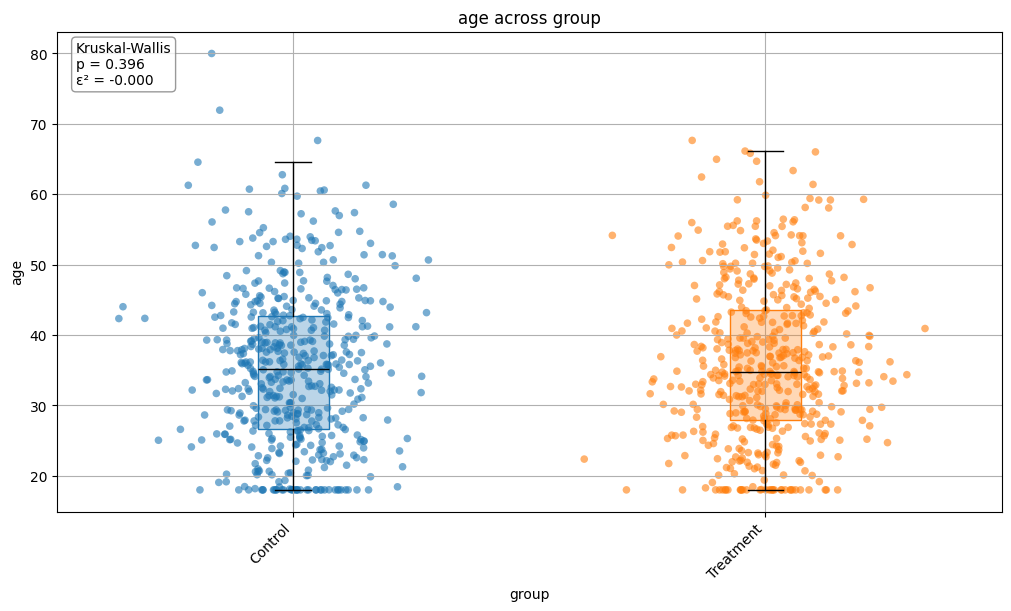

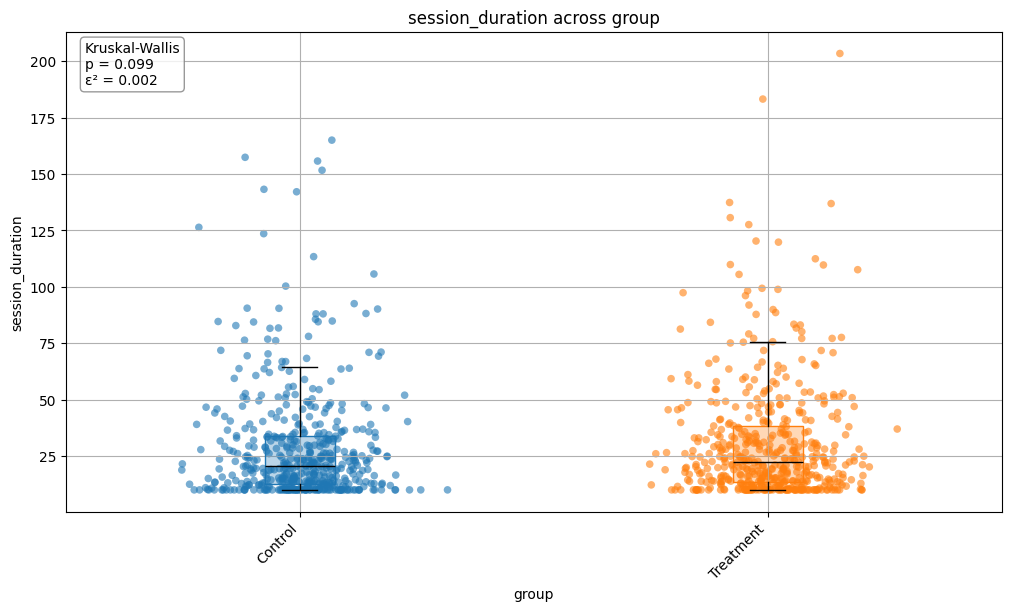

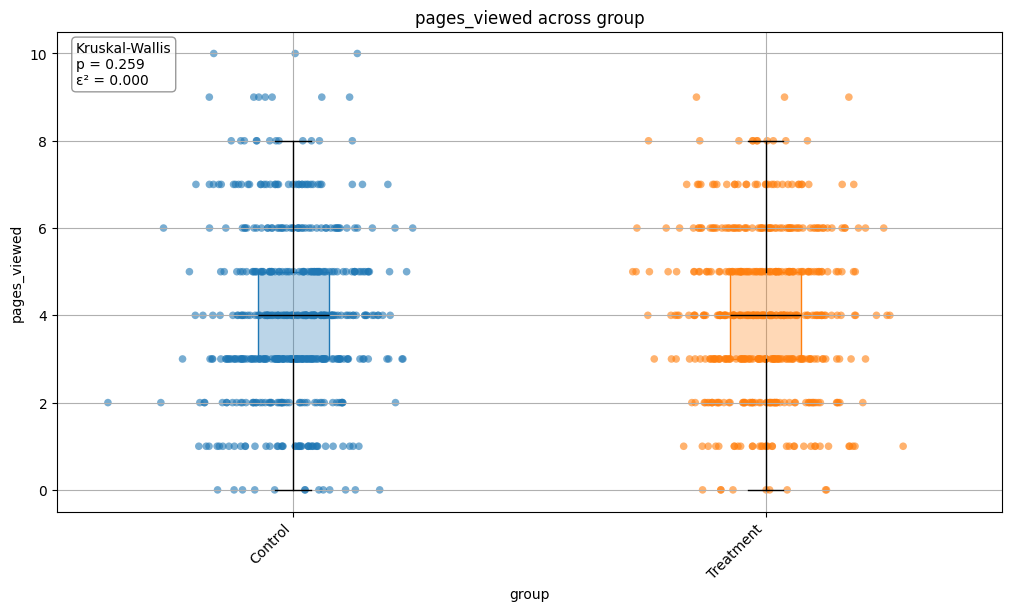

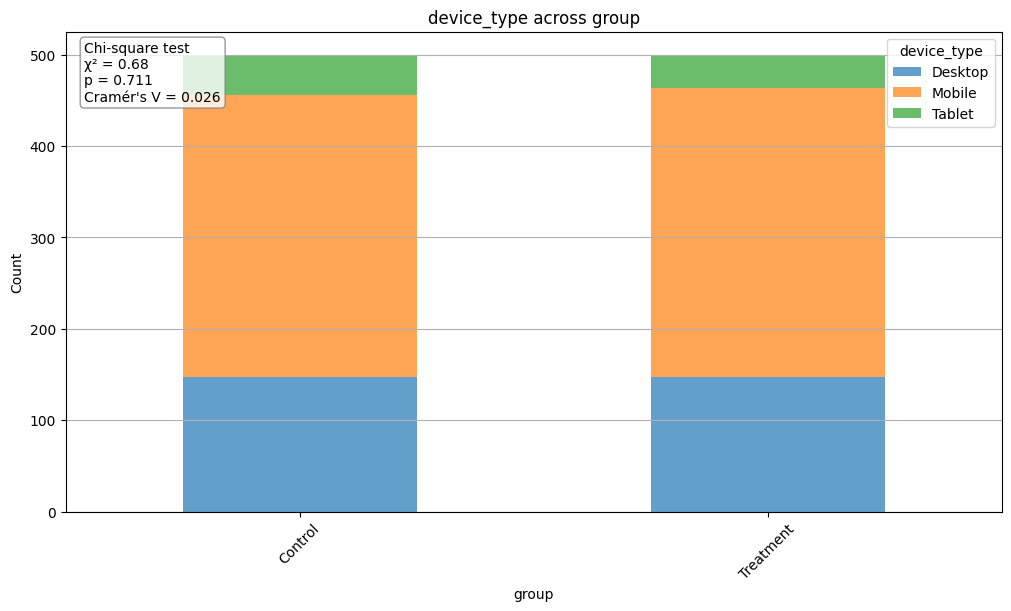

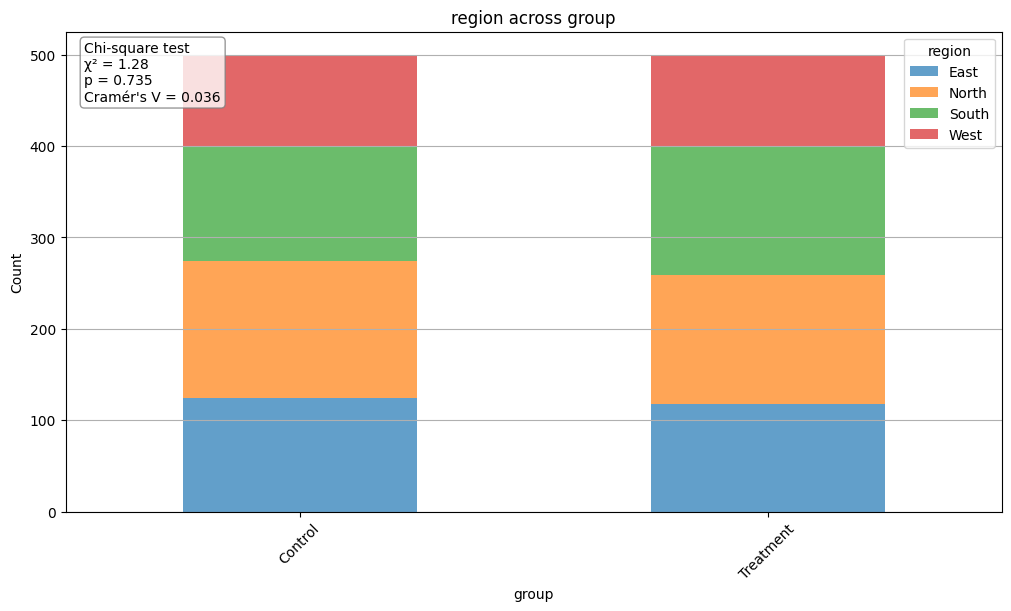

In [23]:
print("🔍 Customized Group Comparison")
print("=" * 50)

# Define weights to emphasize certain metrics
metric_weights = {
    'age': 2.0,              # Age is twice as important
    'session_duration': 1.5,  # Session duration is 1.5x important
    'pages_viewed': 1.0,     # Normal importance
    'device_type': 0.5,      # Less important
    'region': 0.3            # Least important
}

# Run comparison with custom settings
effect_size_sum, summary_df = sut.compare_groups(
    data=ab_test_df,
    grouping_col='group',
    target_cols=['age', 'session_duration', 'pages_viewed', 'device_type', 'region'],
    weights=metric_weights,
    num_test='kruskal',  # Use non-parametric test for numeric variables
    alpha=0.10,          # More lenient significance threshold
    visualize=True       # Generate plots
)

print(f"Overall Weighted Effect Size Sum: {effect_size_sum:.4f}")
print("\nSummary of Group Differences:")
print(summary_df.round(4))

# Display the weights used for each metric
print("\n⚖️ Weights Applied:")
for metric, weight in metric_weights.items():
    print(f"   • {metric}: {weight:.1f}x importance")

# 2. Add Stratified Groups Function

The `add_stratified_groups` function creates balanced experimental groups by maintaining the distribution of key stratification variables. This ensures:

- **Balanced Randomization**: Groups have similar distributions of important characteristics
- **Reduced Confounding**: Minimizes bias from uneven group composition
- **Improved Statistical Power**: More precise effect detection

**Features:**
- Single or multiple column stratification
- Customizable group labels (0/1, control/treatment, etc.)
- Reproducible results with random seed control
- Graceful handling of edge cases

In [24]:
# Create a customer dataset for stratification demo
def create_customer_data(n=1000):
    """Create realistic customer data for stratification."""
    np.random.seed(123)
    
    df = pd.DataFrame({
        'customer_id': range(1, n+1),
        'region': np.random.choice(['North', 'South', 'East', 'West'], n, p=[0.4, 0.3, 0.2, 0.1]),
        'customer_tier': np.random.choice(['Bronze', 'Silver', 'Gold', 'Platinum'], n, p=[0.4, 0.3, 0.2, 0.1]),
        'age_group': np.random.choice(['18-25', '26-35', '36-50', '51+'], n, p=[0.2, 0.3, 0.3, 0.2]),
        'avg_order_value': np.random.lognormal(4, 0.8, n),
        'purchase_frequency': np.random.poisson(3, n),
        'satisfaction_score': np.random.normal(7.5, 1.5, n)
    })
    
    # Ensure realistic ranges
    df['avg_order_value'] = np.clip(df['avg_order_value'], 10, 1000)
    df['satisfaction_score'] = np.clip(df['satisfaction_score'], 1, 10)
    
    return df

customer_df = create_customer_data()
print(f"👥 Created customer dataset with {len(customer_df):,} customers")
print("\n📊 Distribution by Region and Tier:")
print(pd.crosstab(customer_df['region'], customer_df['customer_tier'], margins=True))


👥 Created customer dataset with 1,000 customers

📊 Distribution by Region and Tier:
customer_tier  Bronze  Gold  Platinum  Silver   All
region                                             
East               88    35        16      43   182
North             165    84        44     111   404
South             120    80        35      75   310
West               40    26        11      27   104
All               413   225       106     256  1000


## 2.1 Simple stratification by one stratifier

In [25]:
# Simple stratification by region
print("🎯 Simple Stratification by Region")
print("=" * 50)

df_stratified_simple = sut.add_stratified_groups(
    data=customer_df,
    stratifier_col='region',
    random_seed=42
)

print("Distribution by region and group:")
region_group_dist = pd.crosstab(df_stratified_simple['region'], 
                               df_stratified_simple['stratified_group'], 
                               margins=True)
print(region_group_dist)

# Calculate balance percentages
balance_check = region_group_dist.iloc[:-1, :-1]  # Exclude margins
region_pcts = balance_check.div(balance_check.sum(axis=1), axis=0) * 100
print("\n📈 Percentage distribution (should be ~50/50):")
print(region_pcts.round(1))


🎯 Simple Stratification by Region
Distribution by region and group:
stratified_group    0    1   All
region                          
East               91   91   182
North             202  202   404
South             155  155   310
West               52   52   104
All               500  500  1000

📈 Percentage distribution (should be ~50/50):
stratified_group     0     1
region                      
East              50.0  50.0
North             50.0  50.0
South             50.0  50.0
West              50.0  50.0


## 2.2 Advanced Stratification Scenarios

Let's explore more complex stratification cases:

1. **Custom Group Labels**
   - Using semantic labels like "Control" and "Treatment"
   - Useful for experimental design and A/B testing

2. **Multi-Column Stratification**
   - Many times we will want to stratify on more than one factors
   - `add_stratified_groups` can automatically combine multiple categorical columns into a composite stratifier for you.

In [26]:
# First, let's add a new categorical column that will create some interesting scenarios
customer_df = create_customer_data(n=1000)

# Add a device preference column with some rare categories
device_prefs = np.random.choice(
    ['Mobile', 'Desktop', 'Tablet', 'Smart TV', 'Gaming Console'],
    size=1000,
    p=[0.45, 0.35, 0.15, 0.04, 0.01]  # Intentionally imbalanced
)
customer_df['device_preference'] = device_prefs

print("📊 Data Overview:")
print(f"Total customers: {len(customer_df):,}")
print("\nDevice preference distribution:")
print(customer_df['device_preference'].value_counts())

# Case 1: Custom Group Labels
print("\n🏷️ Case 1: Custom Group Labels")
print("=" * 50)

df_custom_labels = sut.add_stratified_groups(
    customer_df,
    stratifier_col='customer_tier',
    group_labels=('Control', 'Treatment'),
    group_col_name='experiment_group'
)

print("Group sizes with custom labels:")
print(df_custom_labels['experiment_group'].value_counts())
print("\nDistribution of customer_tier in each group:")
print(pd.crosstab(
    df_custom_labels['experiment_group'],
    df_custom_labels['customer_tier'],
    normalize='index'
).round(3))



📊 Data Overview:
Total customers: 1,000

Device preference distribution:
device_preference
Mobile            453
Desktop           359
Tablet            138
Smart TV           38
Gaming Console     12
Name: count, dtype: int64

🏷️ Case 1: Custom Group Labels
Group sizes with custom labels:
experiment_group
Control      500
Treatment    500
Name: count, dtype: int64

Distribution of customer_tier in each group:
customer_tier     Bronze   Gold  Platinum  Silver
experiment_group                                 
Control            0.412  0.226     0.106   0.256
Treatment          0.414  0.224     0.106   0.256


In [ ]:
# Case 2: Combined Column Stratification
print("\n🔄 Case 2: Multi-Column Stratification")
print("=" * 50)

# To leverage a combined stratifier
stratifier_cols = ['region', 'customer_tier']

df_multi = sut.add_stratified_groups(
    customer_df,
    stratifier_col=stratifier_cols,
    group_labels=('A', 'B')
)

# Double checking the balance
df_multi['region_tier'] = customer_df['region'] + "_" + customer_df['customer_tier']
print("\nChecking balance across combined categories:")
print(pd.crosstab(
    df_multi['stratified_group'],
    df_multi['region_tier']
).head())


🔄 Case 2: Multi-Column Stratification

Checking balance across combined categories:
region_tier       East_Bronze  East_Gold  East_Platinum  East_Silver  \
stratified_group                                                       
A                          44         18              8           22   
B                          44         17              8           21   

region_tier       North_Bronze  North_Gold  North_Platinum  North_Silver  \
stratified_group                                                           
A                           82          42              22            55   
B                           83          42              22            56   

region_tier       South_Bronze  South_Gold  South_Platinum  South_Silver  \
stratified_group                                                           
A                           60          40              17            38   
B                           60          40              18            37   

region_tier     

## 2.3 When stratification fails

When stratification fails due to insufficient group sizes (in this case, category 'C' having only one member), the function:

1. Issues a warning about the stratification failure
2. Assigns all rows to the first group label ('Control' in this case)
3. Continues execution without raising an error

This behavior allows the code to continue running while alerting the user to potential data quality issues. In production scenarios, you might want to:

- Pre-filter rare categories before stratification
- Combine rare categories into an "Other" category
- Use a different stratification strategy
- Handle the warning programmatically to take appropriate action

In [30]:
# Create a sample dataset where one category has only one member
np.random.seed(42)
data = pd.DataFrame({
    'category': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'C'],  # C has only one member
    'value': np.random.normal(100, 15, 8)
})

print("Original data distribution:")
print(data.groupby('category').size())
# Try to stratify based on the category column
stratified_data = sut.add_stratified_groups(
    data,
    stratifier_col='category',
    random_seed=42,
    group_labels=('Control', 'Treatment')
)
print("\nResulting group distribution:")
print(stratified_data.groupby('stratified_group').size())

Original data distribution:
category
A    4
B    3
C    1
dtype: int64

Resulting group distribution:
stratified_group
Control    8
dtype: int64


# 3. Optimize Stratification Strategy

The `optimize_stratification_strategy` function automatically tests different stratification approaches to find the best one. It:

- **Tests Multiple Combinations**: 
    - Test and compare all user specified candidate stratifiers and their combinations
    - Automatically generates combinations up to `max_combinations`
    - Includes a random baseline (50/50 assignment) to validate whether stratification actually improves over chance
- **Composite Scoring**: 
    - Combines effect sizes with significance penalties to form the comparison metric
    - User can specify how much they want to penalize a significant test result
    - User can set alpha for significance test 
- **Flexible Weighting**: 
    - User can specify weights for all target columns to prioritizes important variables
- **Comprehensive Results**: 
    - The function provides rankings and detailed analysis comparing all strategies including the random baseline
    - Users can easily see how much improvement stratification provides over random assignment
- **Graceful stratification error handling**:
    - Added intelligent detection when stratification creates only one group (failure case)
    - Graceful skipping of failed strategies with informative warnings
    - Prevents downstream errors and maintains robust optimization

This is especially valuable when you have many potential stratification variables and want to find the optimal approach.

In [31]:
# Find the optimal stratification strategy
print("🚀 Finding Optimal Stratification Strategy")
print("=" * 50)

# Define candidate stratification variables
candidate_stratifiers = ['region', 'customer_tier', 'age_group']
target_metrics = ['avg_order_value', 'purchase_frequency', 'satisfaction_score']

# Run optimization
results = sut.optimize_stratification_strategy(
    data=customer_df,
    candidate_stratifiers=candidate_stratifiers,
    target_metrics=target_metrics,
    max_combinations=2,
    significance_penalty=0.1,
    random_seed=42
)

print(f"🎯 Best Stratification Strategy: {results['best_stratifier']}")
print(f"📊 Number of strategies tested: {len(results['results'])}")

# Display comprehensive overview of all strategies
print("\n🏆 Strategy Performance Overview:")
print(results['summary'].round(4))


🚀 Finding Optimal Stratification Strategy
🎯 Best Stratification Strategy: ['customer_tier', 'age_group']
📊 Number of strategies tested: 7

🏆 Strategy Performance Overview:
                stratifier  effect_size_sum  n_significant  composite_score  \
0  customer_tier_age_group           0.0016              0           0.0016   
1                   region           0.0023              0           0.0023   
2         region_age_group           0.0025              0           0.0025   
3     region_customer_tier           0.0025              0           0.0025   
4                age_group           0.0034              0           0.0034   
5          random_baseline           0.0049              0           0.0049   
6            customer_tier           0.0082              1           0.1082   

   rank  
0     1  
1     2  
2     3  
3     4  
4     5  
5     6  
6     7  


In [32]:
# Apply the best strategy
print(f"\nApplying Best Strategy: Strtify with {results['best_stratifier']}")
df_optimized = sut.add_stratified_groups(
    data=customer_df,
    stratifier_col=results['best_stratifier'],
    group_labels=('Control', 'Treatment'),
    group_col_name='optimized_group',
    random_seed=42
)

# Validate the optimized strategy
effect_size, validation = sut.compare_groups(
    data=df_optimized,
    grouping_col='optimized_group',
    target_cols=target_metrics
)

print(f"\n📋 Validation Results:")
print(f"   Effect Size Sum: {effect_size:.4f}")
print(f"   Significant Differences: {validation['is_significant'].sum()}/{len(target_metrics)}")

if validation['is_significant'].sum() == 0:
    print("\n✅ No significant differences - groups are optimally balanced!")
else:
    print(f"\n⚠️ Some imbalances detected between groups, please check.")


Applying Best Strategy: Strtify with ['customer_tier', 'age_group']

📋 Validation Results:
   Effect Size Sum: 0.0016
   Significant Differences: 0/3

✅ No significant differences - groups are optimally balanced!


🔬 Complete A/B Testing Workflow
📋 Step 1: Experiment Setup
   Experiment: Email Campaign Optimization
   Sample Size: 1,000 customers
   Key Metrics: ['avg_order_value', 'purchase_frequency', 'satisfaction_score', 'customer_tier']

🎯 Step 2: Finding Optimal Stratification
   ✅ Optimal Strategy: Stratify with ['customer_tier', 'age_group']

👥 Step 3: Creating Experimental Groups
   Control Group: 500 customers
   Treatment Group: 500 customers

✅ Step 4: Final Group Validation
   Weighted Effect Size: 0.0059
   Significant Imbalances: 0/4

📊 Step 5: Experiment Readiness Report
🎯 Recommendation: 🟢 EXCELLENT - Proceed with confidence

📋 Experiment Summary:
   • Strategy: ['customer_tier', 'age_group']
   • Total Participants: 1,000
   • Group Balance: 500 / 500
   • Ready for Launch: ✅ Yes


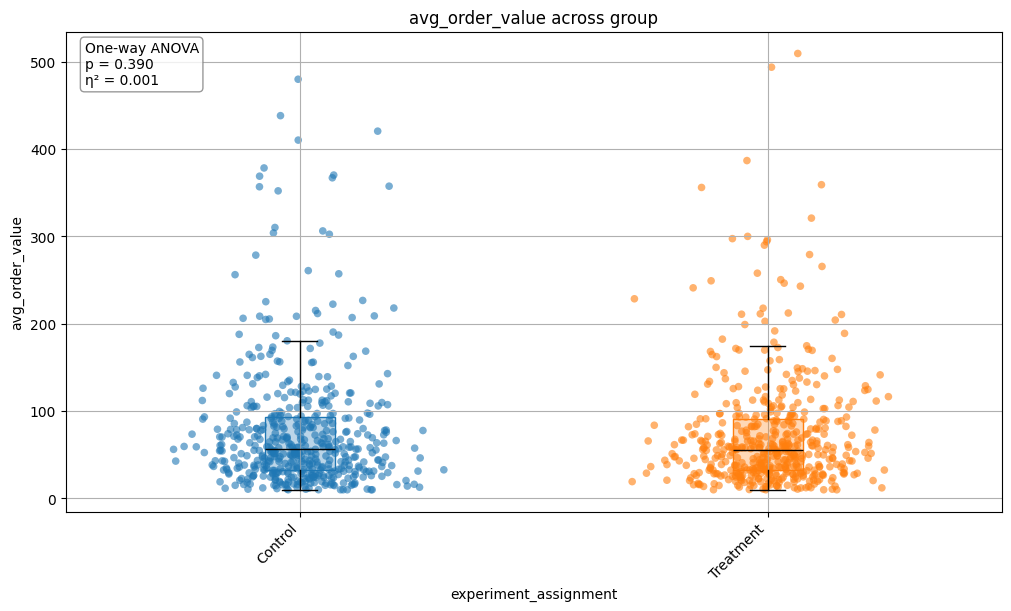

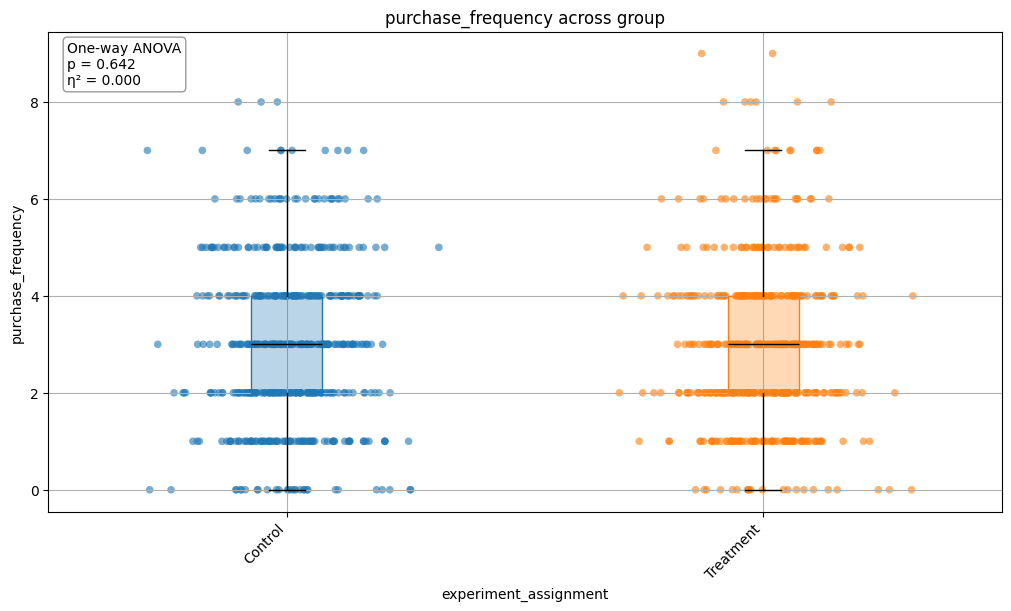

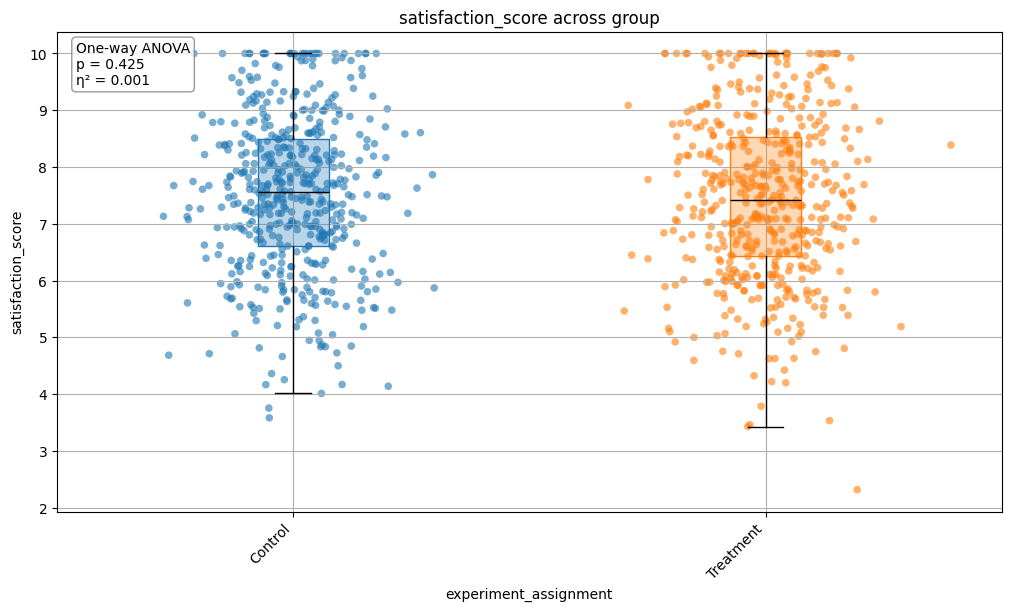

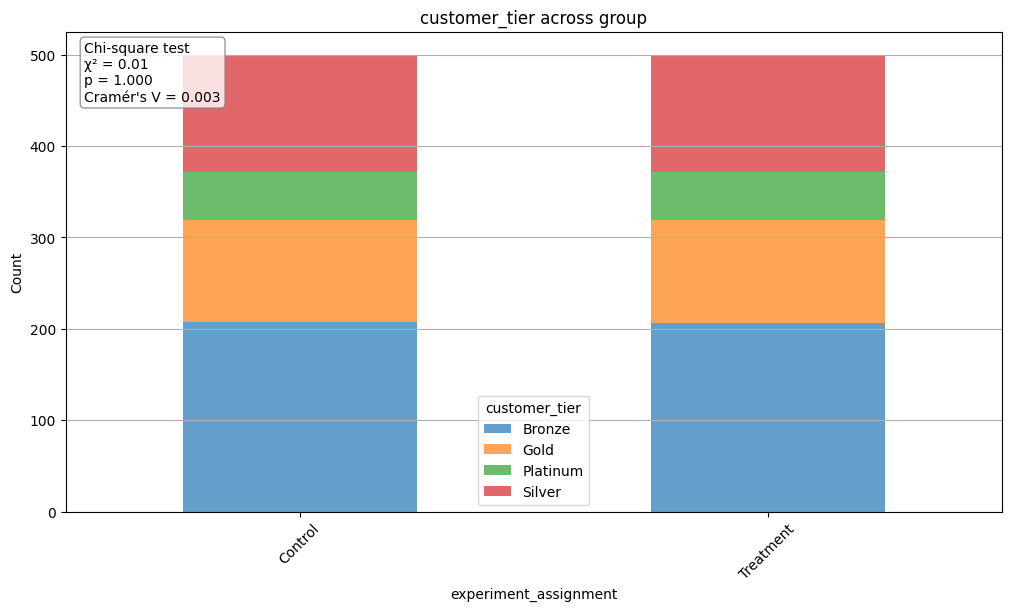

In [33]:
# Complete A/B Testing Workflow
print("🔬 Complete A/B Testing Workflow")
print("=" * 60)

# Step 1: Define the experiment
print("📋 Step 1: Experiment Setup")
experiment_name = "Email Campaign Optimization"
stratification_candidates = ['region', 'customer_tier', 'age_group']
key_metrics = ['avg_order_value', 'purchase_frequency', 'satisfaction_score', 'customer_tier']
business_weights = {
    'avg_order_value': 3.0,      # Revenue impact - highest priority
    'purchase_frequency': 2.0,   # Engagement - high priority
    'satisfaction_score': 1.0    # Experience - important but secondary
}

print(f"   Experiment: {experiment_name}")
print(f"   Sample Size: {len(customer_df):,} customers")
print(f"   Key Metrics: {key_metrics}")

# Step 2: Find optimal stratification
print("\n🎯 Step 2: Finding Optimal Stratification")
optimal_results = sut.optimize_stratification_strategy(
    data=customer_df,
    candidate_stratifiers=stratification_candidates,
    target_metrics=key_metrics,
    weights=business_weights,
    max_combinations=2,
    significance_penalty=0.2,  # Moderate penalty for business use
    random_seed=42
)

optimal_strategy = optimal_results['best_stratifier']
print(f"   ✅ Optimal Strategy: Stratify with {optimal_strategy}")


# Step 3: Create experimental groups
print("\n👥 Step 3: Creating Experimental Groups")
final_experiment_df = sut.add_stratified_groups(
    data=customer_df,
    stratifier_col=optimal_strategy,
    group_labels=('Control', 'Treatment'),
    group_col_name='experiment_assignment',
    random_seed=42
)

group_sizes = final_experiment_df['experiment_assignment'].value_counts()
print(f"   Control Group: {group_sizes['Control']:,} customers")
print(f"   Treatment Group: {group_sizes['Treatment']:,} customers")

# Step 4: Final validation
print("\n✅ Step 4: Final Group Validation")
final_effect_size, final_validation = sut.compare_groups(
    data=final_experiment_df,
    grouping_col='experiment_assignment',
    target_cols=key_metrics,
    weights=business_weights, 
    visualize=True
)

print(f"   Weighted Effect Size: {final_effect_size:.4f}")
print(f"   Significant Imbalances: {final_validation['is_significant'].sum()}/{len(key_metrics)}")

# Step 5: Experiment readiness report
print("\n📊 Step 5: Experiment Readiness Report")
print("="*40)

# Generate recommendation
if final_validation['is_significant'].sum() == 0 and final_effect_size < 0.1:
    recommendation = "🟢 EXCELLENT - Proceed with confidence"
elif final_validation['is_significant'].sum() <= 1 and final_effect_size < 0.2:
    recommendation = "🟡 GOOD - Proceed with minor caution"
else:
    recommendation = "🟠 FAIR - Consider improving stratification design"

print(f"🎯 Recommendation: {recommendation}")
print(f"\n📋 Experiment Summary:")
print(f"   • Strategy: {optimal_strategy}")
print(f"   • Total Participants: {len(final_experiment_df):,}")
print(f"   • Group Balance: {group_sizes['Control']} / {group_sizes['Treatment']}")
print(f"   • Ready for Launch: {'✅ Yes' if 'EXCELLENT' in recommendation or 'GOOD' in recommendation else '⚠️ Review needed'}")


In [13]:
# Quick reference example
print("📚 Quick Reference - Minimal Working Example")
print("=" * 50)

# Simple 3-step process
print("# Step 1: Find best strategy")
print("results = sut.optimize_stratification_strategy(df, ['col1', 'col2'], ['metric1', 'metric2'])")
print("\n# Step 2: Apply best strategy")
print("df_experiment = sut.add_stratified_groups(df, results['best_stratifier'])")
print("\n# Step 3: Validate balance")
print("effect_size, summary = sut.compare_groups(df_experiment, 'stratified_group', ['metric1', 'metric2'])")

print("\n🎉 That's it! Your experiment is ready to launch.")
print("\n💡 Pro tip: Always validate your stratification before running the actual experiment!")


📚 Quick Reference - Minimal Working Example
# Step 1: Find best strategy
results = sut.optimize_stratification_strategy(df, ['col1', 'col2'], ['metric1', 'metric2'])

# Step 2: Apply best strategy
df_experiment = sut.add_stratified_groups(df, results['best_stratifier'])

# Step 3: Validate balance
effect_size, summary = sut.compare_groups(df_experiment, 'stratified_group', ['metric1', 'metric2'])

🎉 That's it! Your experiment is ready to launch.

💡 Pro tip: Always validate your stratification before running the actual experiment!


# 4. Calculating Thresholds by Item

This example demonstrates how to calculate statistical thresholds for different items in a dataset. This is useful for:
- Identifying outliers per item category
- Setting item-specific thresholds for monitoring
- Understanding value distributions across different items

In [14]:
# Create sample data
items = ['A', 'B', 'C']
n_cases = 100

# Generate sample data with different distributions for each item
data = []
for item in items:
    for case_id in range(n_cases):
        # Different distribution parameters for each item
        if item == 'A':
            value = np.random.normal(100, 15)  # Normal distribution
        elif item == 'B':
            value = np.random.exponential(50)  # Exponential distribution
        else:  # item C
            value = np.random.uniform(20, 80)  # Uniform distribution
            
        data.append({
            'item': item,
            'case_id': f'case_{case_id}',
            'value': value
        })

# Create DataFrame
df = pd.DataFrame(data)
print("Sample of the data:")
display(df.head(10))

# Verify primary key
n_records = len(df)
n_unique = df.groupby(['case_id', 'item']).ngroups
print(f"\nTotal records: {n_records}")
print(f"Unique case_id & item combinations: {n_unique}")
print(f"Data has unique primary key (case_id, item): {n_records == n_unique}")

Sample of the data:


,item,case_id,value
0,A,case_0,87.756741
1,A,case_1,101.172146
2,A,case_2,112.924542
3,A,case_3,102.085906
4,A,case_4,76.345053
5,A,case_5,87.957633
6,A,case_6,98.890407
7,A,case_7,98.865016
8,A,case_8,129.588133
9,A,case_9,79.210181



Total records: 300
Unique case_id & item combinations: 300
Data has unique primary key (case_id, item): True


## 4.1 Calculate Thresholds for Each Item

Now we'll demonstrate three different methods for calculating thresholds:
1. Standard deviation based (mean + n*std)
2. IQR based (Q3 + 1.5*IQR)
3. Percentile based (95th percentile)

In [15]:
# Example 1: Items and values (original use case)
thresholds_df = sut.calculate_group_thresholds(df, group_col='item', value_col='value', methods=['std', 'iqr'], visualize_first_group=False)

In [16]:
print(thresholds_df)

  group  count method        mean     median        std   threshold
0     A    100    std  100.030882  98.877711  15.887897  131.806675
1     A    100    iqr  100.030882  98.877711  15.887897  134.279987
2     B    100    std   49.455330  33.885788  52.360486  154.176301
3     B    100    iqr   49.455330  33.885788  52.360486  140.588374
4     C    100    std   51.302619  52.196339  16.965041   85.232702
5     C    100    iqr   51.302619  52.196339  16.965041  111.571859


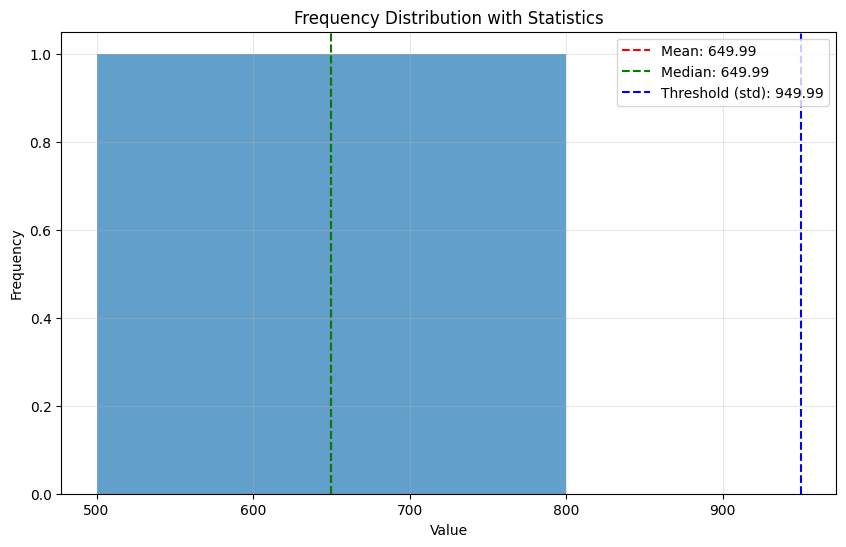

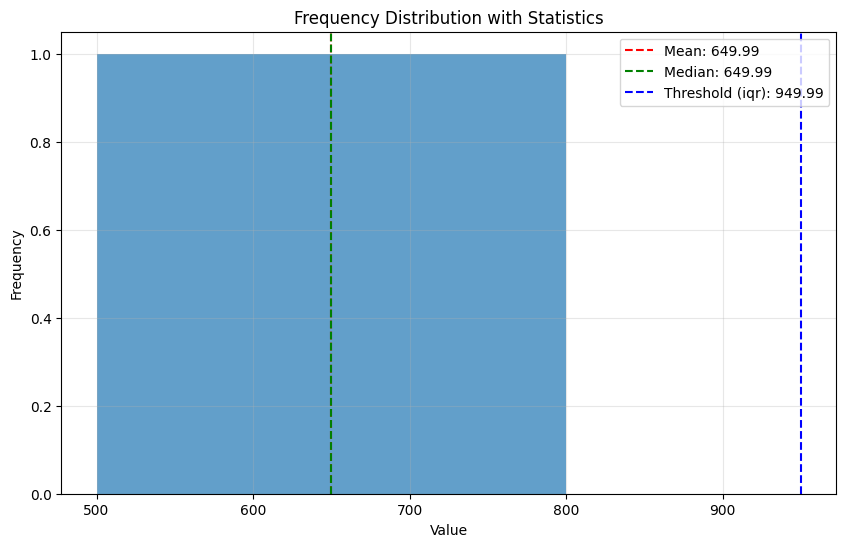

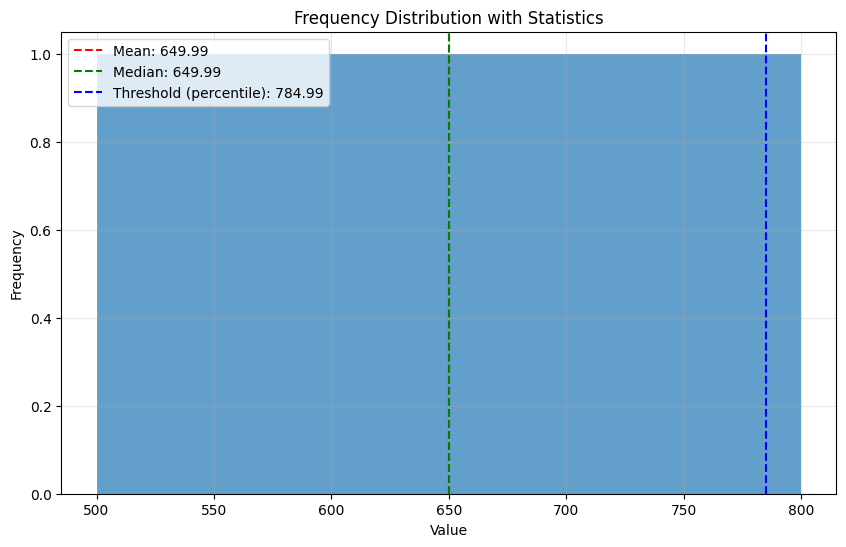

In [17]:
# Example 2: Could be used for product prices
prices_df = pd.DataFrame({
    'product_category': ['Electronics', 'Clothing', 'Electronics', 'Clothing'],
    'price': [499.99, 29.99, 799.99, 39.99]
})
price_thresholds = sut.calculate_group_thresholds(prices_df, 'product_category', 'price')

In [18]:
print(price_thresholds)

         group  count      method    mean  median    std  threshold
0  Electronics      2         std  649.99  649.99  150.0     949.99
1  Electronics      2         iqr  649.99  649.99  150.0     949.99
2  Electronics      2  percentile  649.99  649.99  150.0     784.99
3     Clothing      2         std   34.99   34.99    5.0      44.99
4     Clothing      2         iqr   34.99   34.99    5.0      44.99
5     Clothing      2  percentile   34.99   34.99    5.0      39.49


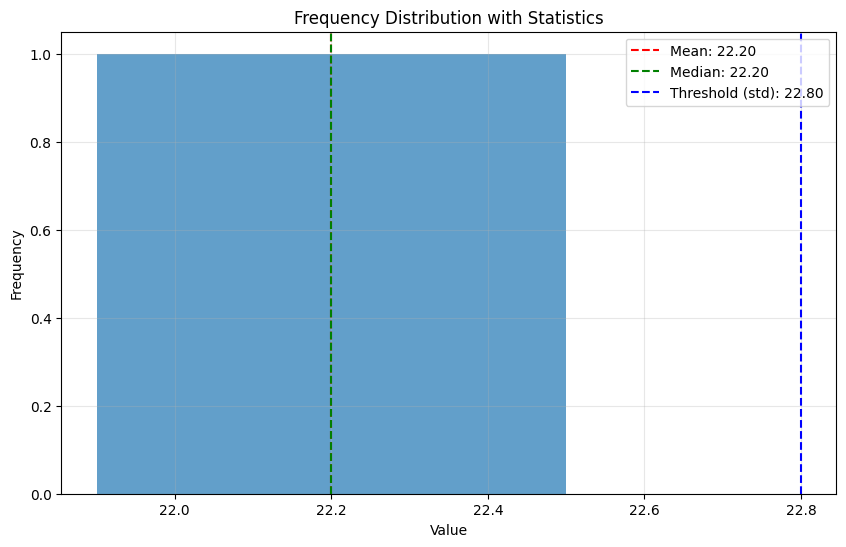

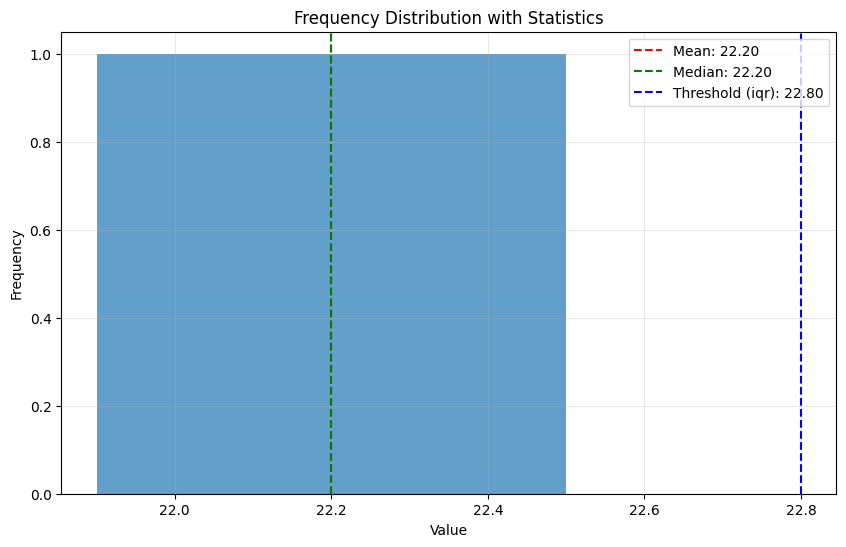

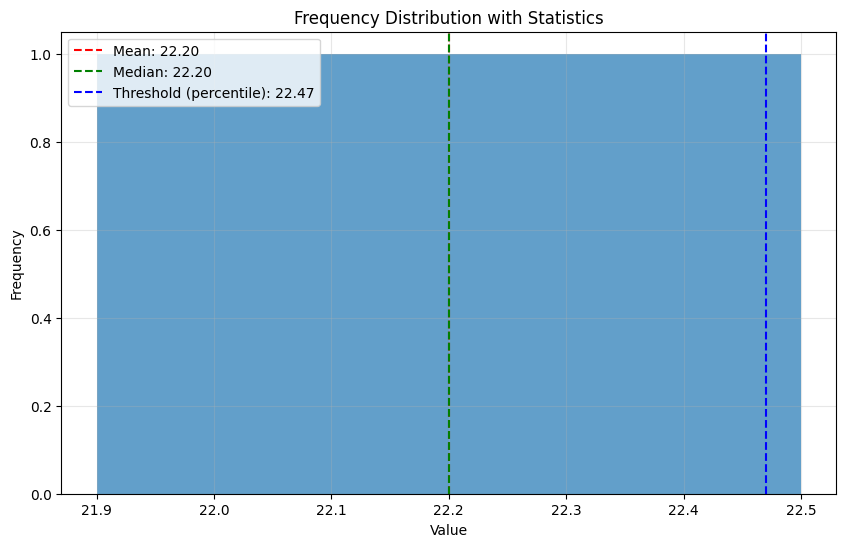

In [19]:
# Example 3: Could be used for temperature monitoring
sensor_df = pd.DataFrame({
    'sensor_location': ['Room1', 'Room2', 'Room1', 'Room2'],
    'temperature': [22.5, 23.1, 21.9, 23.4]
})
temp_thresholds = sut.calculate_group_thresholds(sensor_df, 'sensor_location', 'temperature')